<h1 id="Title">Topographic Differencing and Error Analysis Toolkit</h1>

<h2>Table of Contents</h2>
<ol>
    <li><a href="#introduction">Introduction</a></li>
    <li><a href="#setup">Setup</a>
        <ul>
            <li><a href="#colab">Running the notebook in Colab</a></li>
            <li><a href="#import-libraries">Import required libraries</a></li>
        </ul>
    </li>
    <li><a href="#data-access">Data access, download and pre-processing</a>
        <ul>
            <li><a href="#upload-laz">Option 1: Upload your own point cloud files</a></li>
            <li><a href="#upload-dem">Option 2: Upload your own DEMs</a></li>
            <li><a href="#download-laz">Option 3: Download point clouds using OpenTopography API</a></li>
            <li><a href="#upload-download-mix">Option 4: Upload one file and download another</a></li>
        </ul>
    </li>
    <li><a href="#visualization">Visualization and Derived Rasters</a>
        <ul>
            <li><a href="#plot-dems">Plot the DEMs</a></li>
            <li><a href="#hillshade">Hillshade</a></li>
            <li><a href="#slope">Slope</a></li>
            <li><a href="#aspect">Aspect</a></li>
            <li><a href="#roughness">Roughness</a></li>
        </ul>
    </li>
    <li><a href="#differencing">Differencing</a></li>
    <li><a href="#error-analysis">Error Analysis</a>
        <ul>
            <li><a href="#define-stable-areas">Define stable areas</a></li>
            <li><a href="#descriptive-stats">Descriptive Statistics</a></li>
            <li><a href="#estimate-error">Estimate systematic error</a></li>
        </ul>
    </li>
</ol>

<h2><a id="introduction"></a>1. Introduction</h2>

Vertical topographic differencing is a powerful technique for quantifying landscape change by comparing digital elevation models (DEMs) from different time periods. This notebook provides a comprehensive workflow for performing this analysis, with a strong emphasis on robustly quantifying the associated uncertainty. The methods implemented here are designed to identify and model various error components, including systematic bias and spatially correlated errors, which can otherwise obscure real topographic signals. The core of this workflow is a geostatistical approach that uses variogram analysis to characterize the spatial structure of error, allowing for a more nuanced and accurate assessment of topographic change than traditional methods.

The primary goal of this notebook is to provide a step-by-step guide for users to apply these methods to their own data. The analysis is broken down into several key steps:

* **Data Loading:** Importing the necessary DEMs and other data.
* **Topographic Differencing:** Calculating the difference between the DEMs.
* **Stable/Unstable Area Identification:** Delineating areas that are assumed to be unchanged between surveys to assess the survey-to-survey error.
* **Uncertainty Analysis:** Using variography to model the spatial structure of the error and generate mean uncertainty estimates.

<h2><a id="setup"></a>2. Setup</h2>

<h3><a id="colab"></a>Running the notebook in Colab</h3>

For ease-of-use, it is suggested to launch and execute these notebooks on <a href="https://colab.research.google.com/">Google Colaboratory</a> (Colab, for short), Google's Cloud Platform. Dependencies will be installed on a virtual machine on Google's cloud servers and the code will be executed directly in your browser! A major benefit of this is that you will have direct access to Google's high-end CPU/GPUs and will not have to install any dependencies locally. All deliverables will be saved to your personal Google Drive. To experiment and run one of the below Jupyter Notebooks on Google Colab click the "Open in Colab" badge below.


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Cassandra-Brigham/sage-gage-exercise/blob/main/topographic_processing_notebook.ipynb)


In [ ]:
# This cell only excecutes if you're running on Colab. Installation process takes 2-3 minutes.
import os, sys
if 'google.colab' in sys.modules:
    
  # Mount Google Drive. You will be prompted to grant file I/O access to Drive.
  from google.colab import drive 
  drive.mount('/gdrive/') # Mount Google Drive! 

  # Clone OpenTopography 3DEP Workflow Git Repository
  !git clone https://github.com/Cassandra-Brigham/error_analysis

  #  Install the core dependencies (other than PDAL/GDAL) from requirements.txt
  !pip install -r error_analysis/requirements.txt

  # Install Conda (necessary to install PDAL/GDAL)
  !pip install -q condacolab
  import condacolab
  condacolab.install()

  #kernel will restart. Install PDAL and GDAL with Mamba.
  !mamba install -q python-pdal gdal
  
  # Runtime will restart automatically. Do not rerun above cells.

In [ ]:
# This cell only excecutes if you're running on Colab.
import os, sys
if 'google.colab' in sys.modules:
    # Colab requires proj_lib environment variable to be set manually.
    os.environ['PROJ_LIB'] = '/usr/local/share/proj/'

    !pip install python-dotenv  # if not already installed

    from dotenv import set_key, find_dotenv

    # 1) Locate (or create) your .env
    #    find_dotenv returns the first .env in cwd hierarchy, or '' if none
    env_path = find_dotenv(usecwd=True)
    if not env_path:
        env_path = ".env"
        open(env_path, "a").close()

    # 2) Define your variables
    variables = {
        "OPENTOPOGRAPHY_API_KEY": os.getenv("OPENTOPOGRAPHY_API_KEY", "default_value"),
    }

    # 3) Write/update each key in the .env
    for key, val in variables.items():
        set_key(env_path, key, val)

    print(f".env updated at {env_path}")

from google.colab import output
output.enable_custom_widget_manager()

%cd sage-gage-exercise/ 

<h3><a id="import-libraries"></a>Import required libraries</h3>

This cell imports the necessary Python libraries for data handling and analysis, including custom functions from the provided scripts for differencing, variography, and stable area analysis.

In [ ]:
import colormaps as cmaps
import os
import numpy as np

from differencing_functions import DataAccess, OpenTopographyQuery, Raster, RasterPair, GeoidTransformer, GetDEMs, TerrainDerivatives, TopoDifferencer, LocalDataManager, RasterPairProcessor
from variography_uncertainty import RasterDataHandler, StatisticalAnalysis, VariogramAnalysis, RegionalUncertaintyEstimator
from stable_unstable_areas import TopoMapInteractor, StableAreaRasterizer, StableAreaAnalyzer

<h2><a id="data-access"></a>Data access, download and pre-processing</h2>

This section outlines four options for loading your compare (older) and reference (newer) topographic datasets. [cite_start]The pre-processing steps ensure that both datasets are aligned to a common coordinate reference system (CRS), grid, and vertical datum, which is essential for accurate differencing[cite: 66, 109].

<h3><a id="upload-laz"></a>Option 1: Upload your own point cloud files</h3>

Use this option if you have local `.las` or `.laz` point cloud files. The code will generate Digital Terrain Models (DTMs) and Digital Surface Models (DSMs) from your data and then align them.

In [2]:
folder = 'data/upload_point_clouds/'
os.makedirs(folder, exist_ok=True)

compare_cloud_path = folder + '2016_USACE_NCMP_Topobathy.laz'
reference_cloud_path = folder + 'TX_Coastal_B2_Z15_2018.laz'
ldm_compare_dtm   = LocalDataManager(compare_cloud_path, dem_type="dtm")
ldm_compare_dsm   = LocalDataManager(compare_cloud_path, dem_type="dsm")
ldm_reference_dtm = LocalDataManager(reference_cloud_path, dem_type="dtm")
ldm_reference_dsm = LocalDataManager(reference_cloud_path, dem_type="dsm")


compare_dtm = ldm_compare_dtm.get_raster()
reference_dtm = ldm_reference_dtm.get_raster()
compare_dsm = ldm_compare_dsm.get_raster()
reference_dsm = ldm_reference_dsm.get_raster()

compare_dems = RasterPair(raster1 = compare_dtm, raster2 = compare_dsm)
reference_dems = RasterPair(raster1 = reference_dtm, raster2 = reference_dsm)
_change_dtms = RasterPair(raster1 = reference_dtm, raster2 = compare_dtm)
_change_dsms = RasterPair(raster1 = compare_dsm, raster2 = reference_dsm)

os.makedirs(folder+"processed/", exist_ok=True)

_processed_change_dtms = RasterPairProcessor(raster_pair=_change_dtms, out_dir=folder+"processed/").get_processed_pair()
_processed_change_dsms = RasterPairProcessor(raster_pair=_change_dsms, out_dir=folder+"processed/").get_processed_pair()


☁️ Processing point cloud file: 2016_USACE_NCMP_Topobathy.laz
   - Collection Dates: 2016-09-12 to 2016-09-29
   - Midpoint Epoch:   2016-09-20
✔️ Using epoch 2016-09-20 for CRS via PROJ string.
☁️ Processing point cloud file: 2016_USACE_NCMP_Topobathy.laz
   - Collection Dates: 2016-09-12 to 2016-09-29
   - Midpoint Epoch:   2016-09-20
✔️ Using epoch 2016-09-20 for CRS via PROJ string.
☁️ Processing point cloud file: TX_Coastal_B2_Z15_2018.laz
   - Collection Dates: 2018-01-18 to 2018-01-29
   - Midpoint Epoch:   2018-01-23
✔️ Using epoch 2018-01-23 for CRS via PROJ string.
☁️ Processing point cloud file: TX_Coastal_B2_Z15_2018.laz
   - Collection Dates: 2018-01-18 to 2018-01-29
   - Midpoint Epoch:   2018-01-23
✔️ Using epoch 2018-01-23 for CRS via PROJ string.
Processing raster pair: TX_Coastal_B2_Z15_2018_DTM.tif and 2016_USACE_NCMP_Topobathy_DTM.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 15N (32615)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM.

One of the most significant sources of long-scale error in topographic differencing comes from incorrect vertical coordinate reference system metadata, such as mismatched geoid models or a mix of ellipsoidal and orthometric heights[cite: 105, 107, 108]. The following cells check for and correct these discrepancies by transforming the datasets to a common vertical datum.

In [3]:
print("Compare point cloud original vertical CRS:", ldm_compare_dtm.orig_epsg_vt)
print("Reference point cloud original vertical CRS:", ldm_reference_dtm.orig_epsg_vt)


Compare point cloud original vertical CRS: None
Reference point cloud original vertical CRS: None


In [4]:
# If no vertical CRS is set, assign the CRS based on known metadata
vcrs_compare = 'NAVD88'
geoid_compare = 'geoid18'
vcrs_reference = 'WGS 84 ellipsoid'
geoid_reference = None

In [5]:
os.makedirs(folder+"vert_transformed/", exist_ok=True)

gt_dtms = GeoidTransformer(
        pair=_processed_change_dtms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir="./vert_transformed",
    )

change_dtms = gt_dtms.transform()

gt_dsms = GeoidTransformer(
        pair=_processed_change_dsms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir="./vert_transformed",
    )

change_dsms = gt_dsms.transform()


🚀 Starting vertical transformation...
   - Source HCRS: 32615
   - Source VCRS: NAVD88 (Geoid: geoid18)
   - Target VCRS: WGS 84 ellipsoid (Geoid: None)


/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Transformation complete. New raster saved to: vert_transformed/TX_Coastal_B2_Z15_2018_DTM_utm_regridded_final_vtrans.tif
🚀 Starting vertical transformation...
   - Source HCRS: 32615
   - Source VCRS: NAVD88 (Geoid: geoid18)
   - Target VCRS: WGS 84 ellipsoid (Geoid: None)


/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Transformation complete. New raster saved to: vert_transformed/2016_USACE_NCMP_Topobathy_DSM_utm_regridded_final_vtrans.tif


<h3><a id="upload-dem"></a>Option 2: Upload your own DEMs</h3>

If you already have DEM files (e.g., GeoTIFFs), use this option. The code will ensure they are aligned before proceeding.

In [2]:
folder = 'data/upload_dems/'
os.makedirs(folder, exist_ok=True)

compare_dtm_path = None
reference_dtm_path = None

compare_dsm_path = folder + 'BEG_March_2024.tif'
reference_dsm_path = folder + 'BEG_Aug_2024.tif'

if compare_dtm_path:
    ldm_compare_dtm = LocalDataManager(compare_dtm_path)
    compare_dtm = ldm_compare_dtm.get_raster()
if reference_dtm_path:
    ldm_reference_dtm = LocalDataManager(reference_dtm_path)
    reference_dtm = ldm_reference_dtm.get_raster()

if compare_dsm_path:
    ldm_compare_dsm = LocalDataManager(compare_dsm_path)
    compare_dsm = ldm_compare_dsm.get_raster()
if reference_dsm_path:
    ldm_reference_dsm = LocalDataManager(reference_dsm_path)
    reference_dsm = ldm_reference_dsm.get_raster()

if compare_dtm_path and compare_dsm_path:
    compare_dems = RasterPair(raster1=compare_dtm, raster2=compare_dsm)
else:
    compare_dems = None
    
if reference_dtm_path and reference_dsm_path:
    reference_dems = RasterPair(raster1=reference_dtm, raster2=reference_dsm)
else:
    reference_dems = None

if compare_dtm_path and reference_dtm_path:
    _change_dtms = RasterPair(raster1=reference_dtm, raster2=compare_dtm)
else:
    _change_dtms = None
if compare_dsm_path and reference_dsm_path:
    _change_dsms = RasterPair(raster1=compare_dsm, raster2=reference_dsm)
else:
    _change_dsms = None

📄 Processing raster file: BEG_March_2024.tif
   --- Raster Metadata ---
   - Horizontal EPSG: 26915
   - Vertical EPSG:   Not Found
   - Resolution (X,Y): (1.608609037164885, -1.6739535610644178)
   - Acquisition Date: Not Found
📄 Processing raster file: BEG_Aug_2024.tif
   --- Raster Metadata ---
   - Horizontal EPSG: 26915
   - Vertical EPSG:   Not Found
   - Resolution (X,Y): (2.039439626880226, -2.079851460848849)
   - Acquisition Date: Not Found


/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions_10.py:1583: UserWarning: Could not find a valid acquisition date in the metadata for BEG_March_2024.tif
  warnings.warn(f"Could not find a valid acquisition date in the metadata for {raster_path.name}")
/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions_10.py:1583: UserWarning: Could not find a valid acquisition date in the metadata for BEG_Aug_2024.tif
  warnings.warn(f"Could not find a valid acquisition date in the metadata for {raster_path.name}")


In [3]:
os.makedirs(folder+"processed/", exist_ok=True)

if compare_dtm_path and reference_dtm_path:
    processor_change_dtms = RasterPairProcessor(raster_pair=_change_dtms, out_dir=folder+"processed/")
    _processed_change_dtms = processor_change_dtms.get_processed_pair()
else:
    _processed_change_dtms = None
if compare_dsm_path and reference_dsm_path:
    processor_change_dsms = RasterPairProcessor(raster_pair=_change_dsms, out_dir=folder+"processed/")
    _processed_change_dsms = processor_change_dsms.get_processed_pair()
else:
    _processed_change_dsms = None


Processing raster pair: BEG_March_2024.tif and BEG_Aug_2024.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 15N (32615)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM...
   - Calculating valid data overlap...
   - Regridding BEG_March_2024_utm.tif to match BEG_Aug_2024_utm.tif's grid...
   - Cropping BEG_March_2024_utm_regridded.tif...
   - Cropping BEG_Aug_2024_utm.tif...
✅ Raster pair processing complete.


As with point clouds, uploaded DEMs must be checked for vertical datum consistency.

In [6]:
# If no vertical CRS is set, assign the CRS based on known metadata
vcrs_compare = 'NAVD88'
geoid_compare = 'geoid18'
vcrs_reference = 'NAVD88'
geoid_reference = 'geoid12b'

In [7]:
os.makedirs(folder+"vert_transformed/", exist_ok=True)

if _change_dtms:
    gt_dtms = GeoidTransformer(
            pair=_processed_change_dtms,
            compare_vcrs=vcrs_compare,
            reference_vcrs=vcrs_reference,
            compare_geoid=geoid_compare,
            reference_geoid=geoid_reference,
            out_dir=folder + "vert_transformed/",
        )

    change_dtms = gt_dtms.transform()
else:
    change_dtms = None

if _change_dsms:
    gt_dsms = GeoidTransformer(
        pair=_processed_change_dsms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir=folder + "vert_transformed/",
    )

    change_dsms = gt_dsms.transform()
else:
    change_dsms = None

🚀 Starting vertical transformation...


CRSError: Input is not a CRS: NAVD88

<h3><a id="download-laz"></a>Option 3: Download point clouds using OpenTopography API</h3>

This option allows you to define an area of interest (AOI), search the OpenTopography data catalog for available datasets, and download the point clouds to generate DEMs.

<h4><a id="api-key"></a>Finding and storing your API Key</h4>


We recommend storing your OT API key in a environment variable. This prevents keys from being hardcoded in the source code, reducing the risk of exposure through sharing or version control. It also enhances flexibility, allowing the same code to be used in various environments without changes. Below are the steps to take to store your API key in an environment variable.  

<h5><a id="Linux-macOS"></a>For Linux/macOS</h5>

Open up a Terminal window and find your shell's profile script. For Bash, you might find '~ /.bashrc' or '~ /.bash_profile'.
For Zsh, you might find '~ /.zshrc'.  

```cd ~```  
```ls -a```  

Once you know the name of your shell’s profile script, you can edit it using a text editor that operates in the terminal (like ```nano``` or ```vim```) or out side the terminal with the text editor of your choosing. This example will use '~/.zshrc' as the name of the shell profile script and ```nano``` as the text editor. If the file is read-only, you might need to use ```sudo``` to edit it.  

```nano ~/.zshrc```  

At the end of the .zshrc file, add a line to define your environment variable. 'your_api_key_here' is a stand in for the alphanumeric API key accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."   
 
```export OPENTOPOGRAPHY_API_KEY='your_api_key_here'```


Exit (```control + X``` for ```nano```) and save (```Y``` to ```Save modified buffer (ANSWERING "No" WILL DESTROY CHANGES) ?``` then ```Enter``` for ```nano```).

For your changes to take effect, you need to reload the .zshrc file or restart your terminal. To reload .zshrc without restarting, type the following command in your terminal and press Enter:  

```source ~/.zshrc```  

This will make the OPENTOPOGRAPHY_API_KEY environment variable available in all new terminal sessions.  

<h5><a id="Windows"></a>For Windows</h5> 

1. Search for "Environment Variables" in the Start menu.
1. Click on "Edit the system environment variables."
1. In the System Properties window, click on "Environment Variables."
1. Click on "New" under System variables or User variables depending on your need.
1. Set "Variable name" as OPENTOPOGRAPHY_API_KEY and "Variable value" as your actual API key. Your alphanumeric API key is accessible at [MyOpenTopo](https://portal.opentopography.org/myopentopo) under "Get an API Key."
1. Click OK and apply the changes.

<h4><a id="Load-API-Key"></a>Load API key</h4>

In [2]:
# After setting the environment variable, access your API key in this notebook.
API_Key = os.getenv('OPENTOPO_ADMIN_ENTERPRISE_API_KEY')

# If your API key is not set, you can set it here.
#API_Key = "your_api_key_here"

if API_Key is not None:
    print("API Key loaded successfully!")
else:
    print("Failed to load API Key.")

API Key loaded successfully!


<h4><a id="Define-AOI"></a>Define area of interest</h4>

To specify the geographic region for your dataset search, you have three options. You can 1) manually enter latitude and longitude bounds if you know the exact coordinates of your area of interest; 2) upload a shapefile or GEOJSON to automatically populate the same extent variables; 3) draw a bounding box directly on the interactive map embedded in this notebook: simply click and drag to sketch the rectangle around your target area, and the notebook captures both the corner coordinates and the equivalent WKT polygon for your API queries.

<h5><a id="Option-1-Draw-Map"></a>Option 1: Draw a bounding box on an interactive map</h5>

In [53]:
da = DataAccess()
da.init_ot_catalog_map(zoom=3)

Map(center=[39.8283, -98.5795], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'z…

In [54]:
da.bounds

{'south': 35.123138,
 'west': -120.54491,
 'north': 35.147144,
 'east': -120.502167,
 'polygon_wkt': ['-120.54491, 35.123138, -120.54491, 35.147144, -120.502167, 35.147144, -120.502167, 35.123138, -120.54491, 35.123138']}

<h5><a id="Option-2-Manual-Bounds"></a> Option 2: Define bounds manually</h5>

In [ ]:
da = DataAccess()
south = 41.41898
north = 41.419882
west = -84.982467
east = -84.98148
da.define_bounds_manual(south, north, west, east)

<h5><a id="Option-3-Upload-File"></a> Option 3: Define bounds using an uploaded file</h5>

In [14]:
shapefile_path = "/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Offset mapping - SCEC/GIS/san_jacinto.shp"

da = DataAccess()

da.define_bounds_from_file(shapefile_path, target_crs = 'EPSG:4326')

{'south': 32.79130944963459,
 'west': -116.93032727942875,
 'north': 33.72062768978766,
 'east': -115.57803503695636,
 'polygon_wkt': ['-116.93032727942875, 33.67457519663469, -116.87254408082845, 33.72062768978766, -116.80774049361317, 33.70715146646199, -116.49830336466015, 33.53446917230551, -116.42053906000177, 33.480435035977344, -116.16294480082101, 33.33031374927006, -115.81948578857995, 33.156879269002346, -115.68501834510822, 33.048308147401876, -115.57803503695636, 32.86279561564286, -115.57938537217136, 32.83670416059145, -115.64825246813542, 32.81968386172708, -115.69821487108975, 32.79130944963459, -116.18568588369826, 33.121025783963546, -116.89931103811193, 33.63786514990443, -116.93032727942875, 33.67457519663469']}

<h4><a id="Use-OT-Catalog-comp-ref"></a> Use OT Catalog To Find Paired Compare/Reference Datasets</h4>

This section uses OpenTopography’s `otCatalog` API endpoint to perform a bounding‐box search of available datasets within the area of interest defined above. 

In [55]:
# Initialize the OpenTopography query object with our DataAccess instance
otq = OpenTopographyQuery(da)

otq.query_catalog(
    product_format="PointCloud",    # only return point cloud products; use "Raster" or omit to get all
    include_federated=True,         # include external catalogs (e.g. USGS 3DEP) via OpenTopography
    detail=False,                   # set to True for full metadata; False returns summary fields
    save_as="results.json"          # save raw JSON response to this file for inspection or reuse
)

# Show the first few rows of the catalog dataframe
otq.catalog_df

Name       ID type  \
0  PG&E Diablo Canyon Power Plant (DCPP): Los Oso...    opentopoID   
1    2011 PGE DCPP Lidar: Los Osos, CA Central Coast        NOAAID   
2                                 CA FEMA Z4 B2 2018  USGS_3DEP_ID   

  Data Source           Property ID Horizontal EPSG  \
0          ot  OTLAS.022013.26910.3           26910   
1        noaa                  3651            6339   
2        usgs    CA_FEMA_Z4_B2_2018            3857   

              Vertical Coordinates  \
0                NAVD88 (GEOID 03)   
1                    NAVD88 height   
2  NAVD88 height - Geoid12B (ftUS)   

                                          Clean Name   StartDate     EndDate  
0  PG_E_Diablo_Canyon_Power_Plant_DCPP_Los_Osos_C...  2011-03-17  2011-03-31  
1      2011_PGE_DCPP_Lidar_Los_Osos_CA_Central_Coast  2011-03-17  2011-03-31  
2                                 CA_FEMA_Z4_B2_2018  2018-01-22  2018-04-22

<h4><a id="Select-Compare-Ref"></a> Select compare/reference datasets for differencing</h4>

In [56]:
# choose the indices of the desired reference and compare datasets 
compare_index   = 0   # Older/pre-event dataset
reference_index = 2   # Younger/post-event dataset

# now tell the query object which ones to use as which
otq.pick(compare_index, reference_index)


⚠️  Vertical CRSs differ between datasets
🔹 Compare Epoch: 2011-03-24
🔹 Reference Epoch: 2018-03-08


(Name                    PG&E Diablo Canyon Power Plant (DCPP): Los Oso...
 ID type                                                        opentopoID
 Data Source                                                            ot
 Property ID                                          OTLAS.022013.26910.3
 Horizontal EPSG                                                     26910
 Vertical Coordinates                                    NAVD88 (GEOID 03)
 Clean Name              PG_E_Diablo_Canyon_Power_Plant_DCPP_Los_Osos_C...
 StartDate                                                      2011-03-17
 EndDate                                                        2011-03-31
 Name: 0, dtype: object,
 Name                                 CA FEMA Z4 B2 2018
 ID type                                    USGS_3DEP_ID
 Data Source                                        usgs
 Property ID                          CA_FEMA_Z4_B2_2018
 Horizontal EPSG                                    3857
 Vertical Coord

The OpenTopography API will return the geoid model (when available) used for each DEM in the metadata. 

If the vertical datum of the DEMs is not the same, we will get a warning. We need to transform one of them to match the other (here, we default to the younger/reference dataset).

We can use the metadata to transform the DEMs to a common vertical datum later.

<h4><a id="Get-DEMs"></a> Download topographic data and interpolate Digital Elevation Models </h4>

In [57]:
# Initialize the DEM interpolation/download object with our DataAccess and OpenTopographyQuery instances
gdems = GetDEMs(da, otq)

# Folder where downloaded DEMs and intermediate files will be saved

folder = "data/OT_API_download/"
os.makedirs(folder, exist_ok=True)

# Base name for output files (DEM files will be named like "output_name" + "_compare_DTM.tif", etc.)
output_name = "example"

In [58]:
gdems.dem_download_workflow(
        folder,
        output_name,
        API_Key,                           
        dem_resolution = 1.0,           
        dataset_type = "compare",
        epoch = otq.compare_epoch,           
        filterNoise = True,             
        reclassify = False,         
        savePointCloud = False,         
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    )           
    

gdems.dem_download_workflow(
        folder,
        output_name,
        API_Key,
        dem_resolution = 1.0,
        dataset_type = "reference",
        epoch = otq.reference_epoch,  
        filterNoise = True,
        reclassify = False,
        savePointCloud = False,
        pc_resolution = 0.1,            
        outCRS = "WGS84 UTM",   
        method="idw",                  
        nodata=-9999,                   
        max_dist=50,                   
        smooth_iter=0                   
    ) 

/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Using epoch 2011-03-24 for compare dataset via PROJ string.
✔️ Using epoch 2018-03-08 for reference dataset via PROJ string.


In [29]:
os.makedirs(folder+"processed/", exist_ok=True)

compare_dtm = Raster(folder+output_name+"_compare_DTM.tif")
compare_dsm = Raster(folder+output_name+"_compare_DSM.tif")
reference_dtm = Raster(folder+output_name+"_reference_DTM.tif")
reference_dsm = Raster(folder+output_name+"_reference_DSM.tif")

compare_dems = RasterPair(raster1 = compare_dtm, raster2 = compare_dsm)
reference_dems = RasterPair(raster1 = reference_dtm, raster2 = reference_dsm)
_change_dtms = RasterPair(raster1 = compare_dtm, raster2 = reference_dtm)
_change_dsms = RasterPair(raster1 = compare_dsm, raster2 = reference_dsm)

_processed_change_dtms = RasterPairProcessor(raster_pair=_change_dtms, out_dir=folder+"processed/").get_processed_pair()
_processed_change_dsms = RasterPairProcessor(raster_pair=_change_dsms, out_dir=folder+"processed/").get_processed_pair()

Processing raster pair: example_compare_DTM.tif and example_reference_DTM.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 6N (32606)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM...
   - Calculating valid data overlap...
   - Regridding example_compare_DTM_utm.tif to match example_reference_DTM_utm.tif's grid...
   - Cropping example_compare_DTM_utm_regridded.tif...
   - Cropping example_reference_DTM_utm.tif...
✅ Raster pair processing complete.
Processing raster pair: example_compare_DSM.tif and example_reference_DSM.tif
   - Determined target UTM CRS: WGS 84 / UTM zone 6N (32606)
   - Reprojecting raster 1 to UTM...
   - Reprojecting raster 2 to UTM...
   - Calculating valid data overlap...
   - Regridding example_compare_DSM_utm.tif to match example_reference_DSM_utm.tif's grid...
   - Cropping example_compare_DSM_utm_regridded.tif...
   - Cropping example_reference_DSM_utm.tif...
✅ Raster pair processing complete.


<h4><a id="Geoid"></a> Transform vertical datum of compare dataset (if necessary) </h4>

Here again, we check and transform the vertical datums to ensure consistency between the downloaded datasets.

In [30]:
print(f'Vertical CRS info - compare: {otq.catalog_df.iloc[compare_index,5]}')
print(f'Vertical CRS info - reference: {otq.catalog_df.iloc[reference_index,5]}')

Vertical CRS info - compare: NAVD88 - Geoid09 (Alaska only) (Meters)
Vertical CRS info - reference: Ellipsoid


In [33]:
vcrs_compare = 'NAVD88'
geoid_compare = 'geoid09alaska'
vcrs_reference = 'Ellipsoid'
geoid_reference = None

In [35]:
os.makedirs(folder+"vert_transformed/", exist_ok=True)

if _change_dtms:
    gt_dtms = GeoidTransformer(
            pair=_processed_change_dtms,
            compare_vcrs=vcrs_compare,
            reference_vcrs=vcrs_reference,
            compare_geoid=geoid_compare,
            reference_geoid=geoid_reference,
            out_dir=folder + "vert_transformed/",
        )

    change_dtms = gt_dtms.transform()
else:
    change_dtms = None

if _change_dsms:
    gt_dsms = GeoidTransformer(
        pair=_processed_change_dsms,
        compare_vcrs=vcrs_compare,
        reference_vcrs=vcrs_reference,
        compare_geoid=geoid_compare,
        reference_geoid=geoid_reference,
        out_dir=folder + "vert_transformed/",
    )

    change_dsms = gt_dsms.transform()
else:
    change_dsms = None

🚀 Starting vertical transformation...
   - Source HCRS: 32606
   - Source VCRS: NAVD88 (Geoid: geoid09alaska)
   - Target VCRS: Ellipsoid (Geoid: None)
✔️ Transformation complete. New raster saved to: data/OT_API_download/vert_transformed/example_compare_DTM_utm_regridded_final_vtrans.tif
🚀 Starting vertical transformation...
   - Source HCRS: 32606
   - Source VCRS: NAVD88 (Geoid: geoid09alaska)
   - Target VCRS: Ellipsoid (Geoid: None)


/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/pyproj/crs/crs.py:1295: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


✔️ Transformation complete. New raster saved to: data/OT_API_download/vert_transformed/example_compare_DSM_utm_regridded_final_vtrans.tif


<h3><a id="upload-download-mix"></a>Option 4: Upload one file and download another</h3>

<h2><a id="visualization"></a>Visualization and Derived Rasters</h2>

This section focuses on visualizing the results and creating derived topographic products like hillshades and slope maps, which are useful for interpreting the observed changes[cite: 206].

<h3><a id="plot-dems"></a>Plot the DEMs</h3>



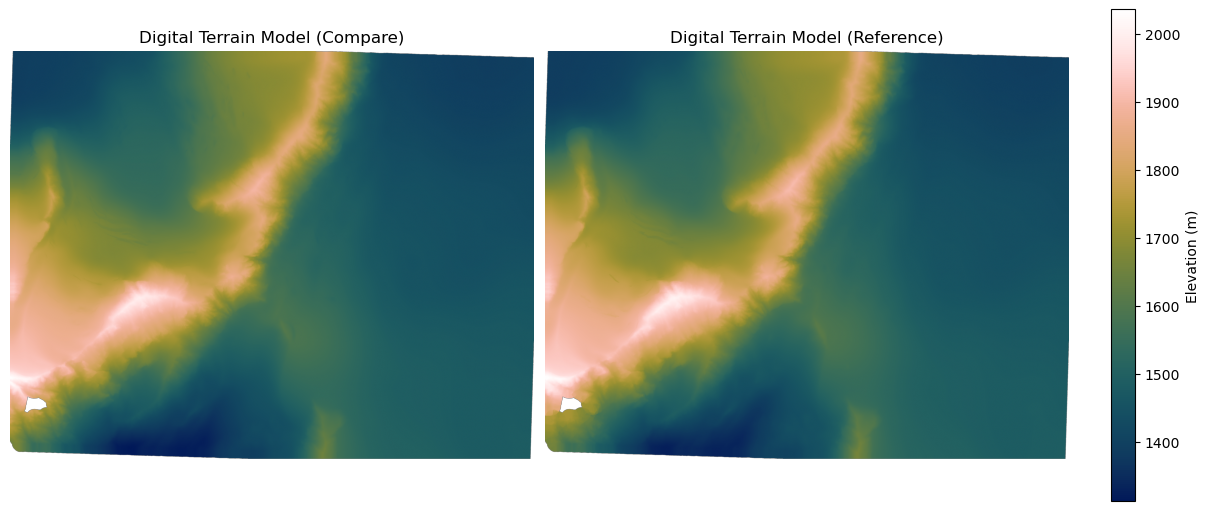

In [36]:
if change_dtms is not None:
    
    fig = change_dtms.plot_pair(
            overlay = None,
            titles=("Digital Terrain Model (Compare)", "Digital Terrain Model (Reference)"),
            base_cmap=cmaps.batloww,
            legend = "Elevation (m)",
        )

<h3><a id="hillshade"></a>Hillshade</h3>

In [37]:
out_folder_der = folder+"derivatives/"
os.makedirs(out_folder_der, exist_ok=True)


td = TerrainDerivatives(out_folder_der)

if change_dtms is not None:
    compare_hillshade_dtm = Raster(td.hillshade(compare_dtm.path, azimuth=315, altitude=45))
    reference_hillshade_dtm = Raster(td.hillshade(reference_dtm.path, azimuth=315, altitude=45))
    hillshades_dtm = RasterPair(raster1 = compare_hillshade_dtm, raster2 = reference_hillshade_dtm)

if change_dsms is not None:
    compare_hillshade_dsm = Raster(td.hillshade(compare_dsm.path, azimuth=315, altitude=45))
    reference_hillshade_dsm = Raster(td.hillshade(reference_dsm.path, azimuth=315, altitude=45))
    hillshades_dsm = RasterPair(raster1 = compare_hillshade_dsm.path, raster2 = reference_hillshade_dsm.path)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions_9.py:115: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


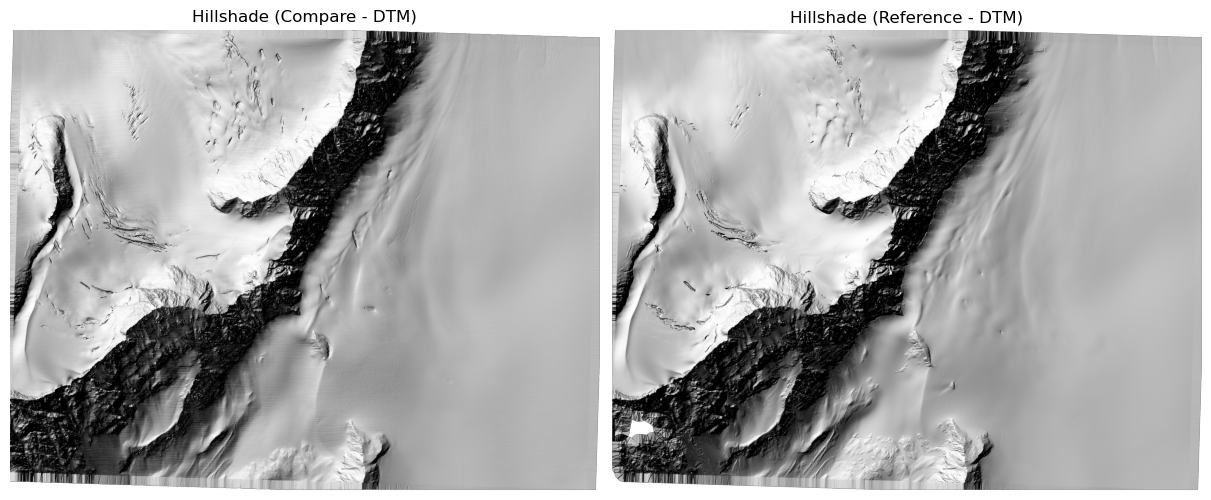

In [39]:
fig = hillshades_dtm.plot_pair(
        overlay = None,
        titles=("Hillshade (Compare - DTM)", "Hillshade (Reference - DTM)"),
        base_cmap=cmaps.gray,
    )

<h3><a id="slope"></a>Slope</h3>

In [40]:
if change_dtms is not None:
    compare_slope_dtm = Raster(td.slope(compare_dtm.path))
    reference_slope_dtm = Raster(td.slope(reference_dtm.path))
    slope_dtm = RasterPair(raster1 = compare_slope_dtm, raster2 = reference_slope_dtm)

if change_dsms is not None:
    compare_slope_dsm = Raster(td.slope(compare_dsm.path))
    reference_slope_dsm = Raster(td.slope(reference_dsm.path))
    slope_dsm = RasterPair(raster1 = compare_slope_dsm, raster2 = reference_slope_dsm)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions_9.py:115: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


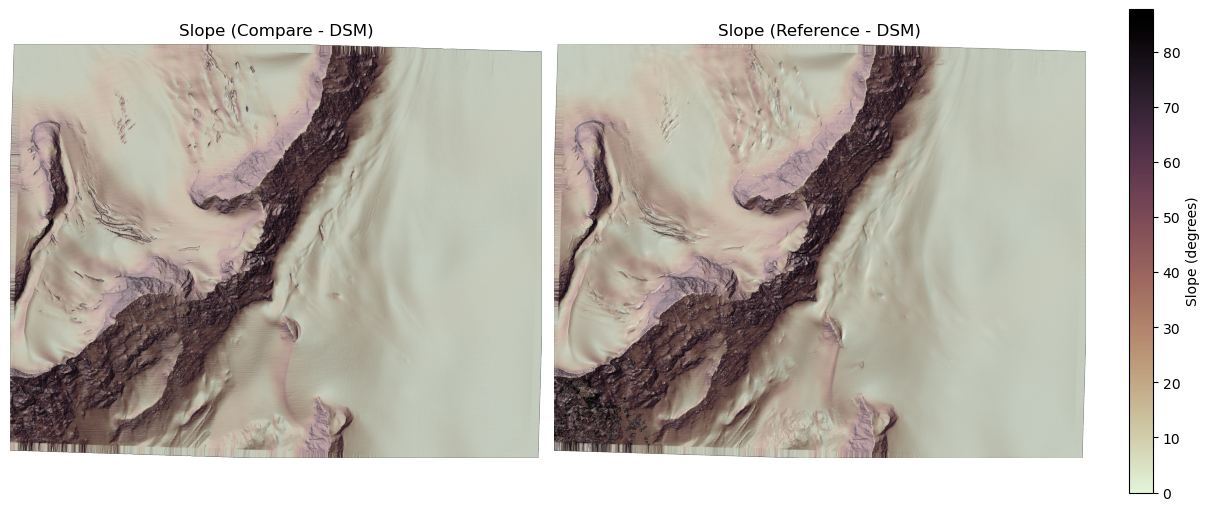

In [41]:
fig = slope_dsm.plot_pair(
        overlay = compare_hillshade_dsm,
        overlay_alpha = 0.5,
        titles=("Slope (Compare - DSM)", "Slope (Reference - DSM)"),
        base_cmap=cmaps.sepia_r,
        legend = "Slope (degrees)",
        overlay_cmap=cmaps.neutral,
          
    )

<h3><a id="aspect"></a>Aspect</h3>

In [42]:
if change_dtms is not None:
    compare_aspect_dtm = Raster(td.aspect(compare_dtm.path))
    reference_aspect_dtm = Raster(td.aspect(reference_dtm.path))
    aspect_dtm = RasterPair(raster1 = compare_aspect_dtm, raster2 = reference_aspect_dtm)

if change_dsms is not None:
    compare_aspect_dsm = Raster(td.aspect(compare_dsm.path))
    reference_aspect_dsm = Raster(td.aspect(reference_dsm.path))
    aspect_dsm = RasterPair(raster1 = compare_aspect_dsm, raster2 = reference_aspect_dsm)


/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions_9.py:115: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


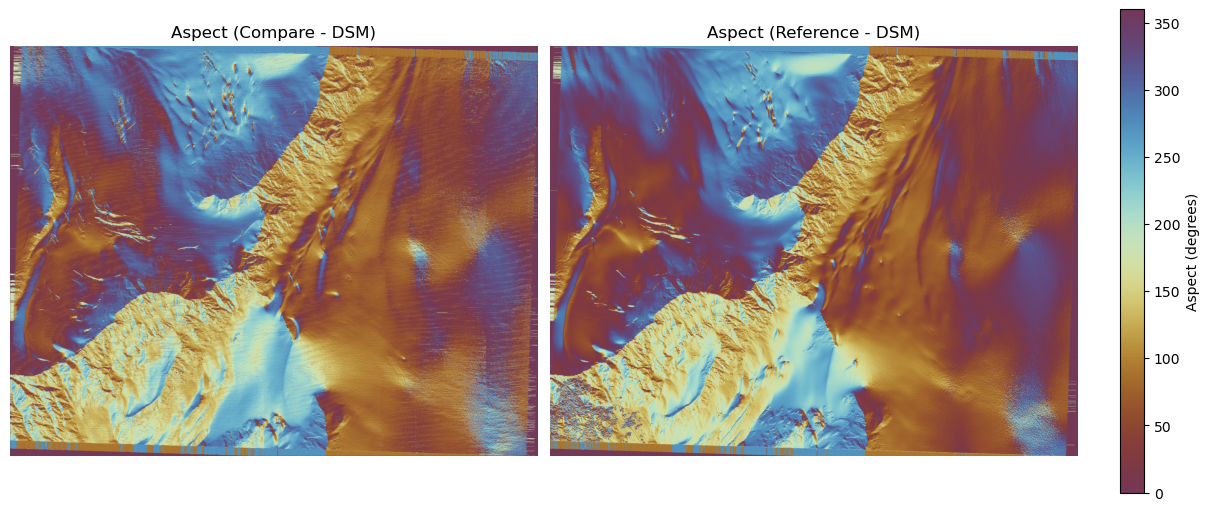

In [43]:
fig = aspect_dsm.plot_pair(
        overlay = None,
        titles=("Aspect (Compare - DSM)", "Aspect (Reference - DSM)"),
        base_cmap=cmaps.romao,
        legend = "Aspect (degrees)",
    )

<h3><a id="roughness"></a>Roughness</h3>

In [44]:
if change_dtms is not None:
    compare_roughness_dtm = Raster(td.roughness(compare_dtm.path))
    reference_roughness_dtm = Raster(td.roughness(reference_dtm.path))
    roughness_dtm = RasterPair(raster1 = compare_roughness_dtm, raster2 = reference_roughness_dtm)

if change_dsms is not None:
    compare_roughness_dsm = Raster(td.roughness(compare_dsm.path))
    reference_roughness_dsm = Raster(td.roughness(reference_dsm.path))
    roughness_dsm = RasterPair(raster1 = compare_roughness_dsm, raster2 = reference_roughness_dsm)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/differencing_functions_9.py:115: UserWarning: Raster grid mismatch – reprojecting the larger raster to match the smaller.
  warnings.warn("Raster grid mismatch – reprojecting the larger raster to match the smaller.")


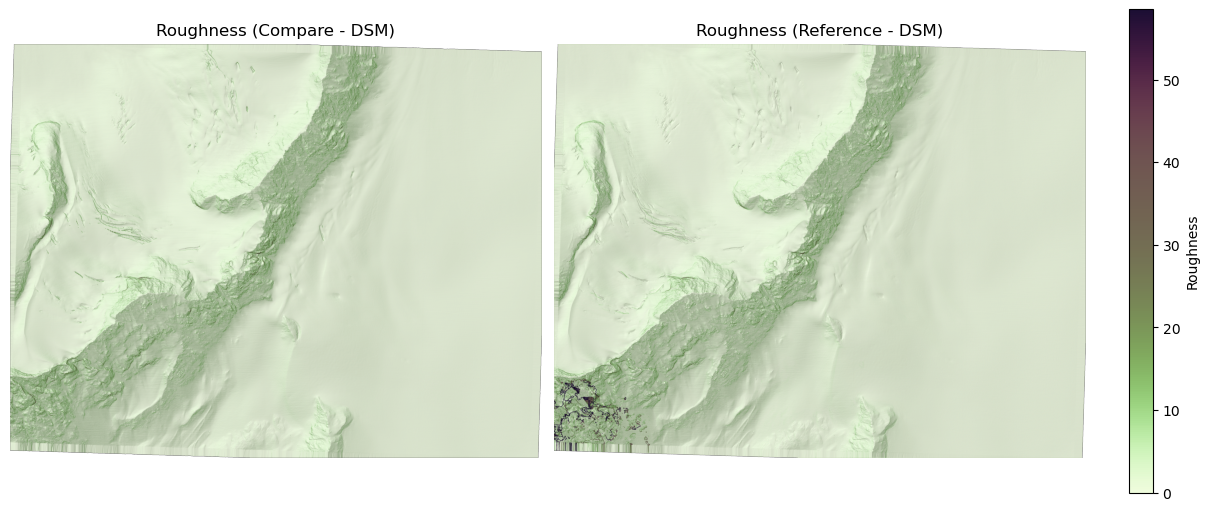

In [45]:
fig = roughness_dsm.plot_pair(
        overlay = compare_hillshade_dsm,
        overlay_alpha = 0.3,
        titles=("Roughness (Compare - DSM)", "Roughness (Reference - DSM)"),
        base_cmap=cmaps.tokyo_r,
        legend = "Roughness",
        overlay_cmap=cmaps.neutral,
    )

<h2><a id="differencing"></a>Differencing</h2>

Topographic differencing, or raster subtraction, is the cell-by-cell subtraction of two aligned DEMs to produce a DEM of Difference (DoD) that quantifies vertical change[cite: 66, 67].

In [46]:
out_folder_diff = folder+"differencing/"
os.makedirs(out_folder_diff, exist_ok=True)

topodiff = TopoDifferencer(out_folder_diff)

In [47]:
if change_dtms is not None:
    dtm_diff = topodiff.save_difference_raster(change_dtms, 'dtm_diff')

if change_dsms is not None:
    dsm_diff = topodiff.save_difference_raster(change_dsms, 'dsm_diff')


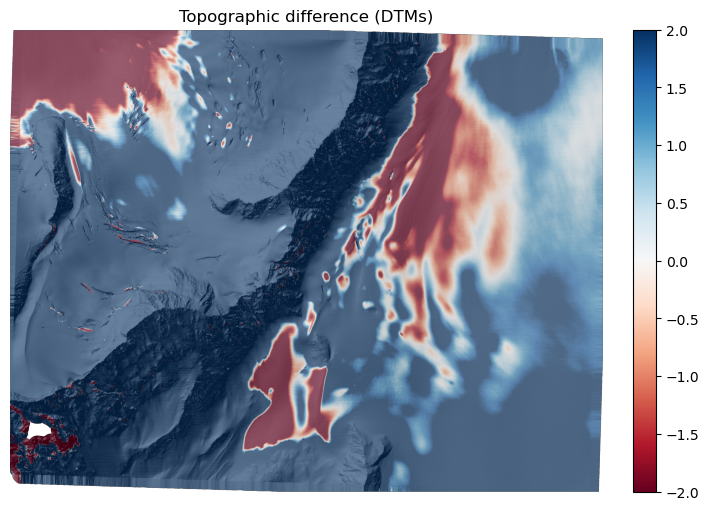

In [50]:
fig = topodiff.plot_difference(
        diff_path = dtm_diff.path,
        overlay = compare_hillshade_dtm,
        cmap="RdBu",
        vmin = -2,
        vmax = 2,
        center_zero = True,
        overlay_alpha = 0.4,
        title = "Topographic difference (DTMs)",
)

<h2><a id="error-analysis"></a>Error Analysis</h2>

<h3><a id="define-stable-areas"></a>Define stable areas</h3>

A key part of this workflow is the use of **stable areas**—regions where no topographic change is expected—to characterize the error between the two surveys. This interactive map allows you to manually draw polygons over areas you consider stable (e.g., roads, bedrock outcrops, undisturbed ground). [cite_start]The elevation differences within these areas are then used to model the uncertainty[cite: 220, 314, 315].

In [41]:
out_folder_poly = folder+"polygons/"
os.makedirs(out_folder_poly, exist_ok=True)


interactor = TopoMapInteractor(
    topo_diff_path=dsm_diff.path,
    hillshade_path=compare_hillshade_dsm.path,
    output_dir=out_folder_poly
)

interactor.map

Map(center=[29.01389231380697, -95.20955165650236], controls=(ZoomControl(options=['position', 'zoom_in_text',…

In [42]:
interactor.stable_geoms

[<POLYGON ((-95.209 29.015, -95.218 29.008, -95.217 29.008, -95.214 29.009, -...>,
 <POLYGON ((-95.201 29.021, -95.202 29.02, -95.203 29.019, -95.203 29.017, -9...>]

<h3><a id="descriptive-stats"></a>Descriptive Statistics</h3>

In [ ]:
stable_polys, _ = interactor.get_geodataframes()

# one combined mask
rasterizer_stable = StableAreaRasterizer(interactor.topo_diff.path, stable_polys, nodata=-9999)
analyzer_stable = StableAreaAnalyzer(rasterizer_stable)

# Combined-area stats
df_all_stable_polys = analyzer_stable.stats_all(folder+"polygons/combined_stable.tif")

# Per-area stats
df_each_stable_poly = analyzer_stable.stats_each(folder+"polygons/each_stable/")


In [44]:
df_all_stable_polys

mean    median   mode       std  variance       min      max  \
all_areas  0.03032  0.033307  0.048  0.083233  0.006928 -1.314433  1.57864   

           skewness   kurtosis  0.5_percentile  99.5_percentile  
all_areas -0.632199  18.699402       -0.247227         0.261699

In [45]:
df_each_stable_poly

mean    median      mode       std  variance       min       max  \
area_id                                                                         
0        0.034599  0.036550 -0.012155  0.083276  0.006935 -1.314433  1.578640   
1        0.014331  0.020954  0.063615  0.081095  0.006576 -0.802287  0.731711   

         skewness   kurtosis  0.5_percentile  99.5_percentile  
area_id                                                        
0       -0.616059  21.857384       -0.238273         0.264342  
1       -0.769929   7.386551       -0.277261         0.240916

<h3><a id="estimate-error"></a>Estimate systematic error</h3>

In [46]:
vert_diff_path_dtm = folder+"polygons/combined_stable.tif"
output_path = folder+"polygons/combined_stable_bias_removed.tif"

unit = "m"
dem_resolution = 1.0

In [47]:
#Load raster data
raster_data_handler_dtm=RasterDataHandler(vert_diff_path_dtm, unit, dem_resolution)
raster_data_handler_dtm.load_raster()

vert_diff_array_dtm = raster_data_handler_dtm.data_array

#With the assumption that the distribution of vertical differences should be centered on zero given a large enough area, let's take the median as the measure of vertical bias.
vertical_bias = np.median(vert_diff_array_dtm)

#Get a measure of the uncertainty in the median value by bootstrap resampling (10% of the total observations, 1000x)
stats_dtm = StatisticalAnalysis(raster_data_handler_dtm)
median_uncertainty = stats_dtm.bootstrap_uncertainty_subsample()

#Subtract the vertical bias from the original raster and save as a file
raster_data_handler_dtm.subtract_value_from_raster(output_path, vertical_bias)

#Create new raster handling instance for modified raster, load raster and create data array
raster2_data_handler=RasterDataHandler(output_path, unit, dem_resolution)
raster2_data_handler.load_raster()


In [48]:
vertical_bias

np.float32(0.033307195)

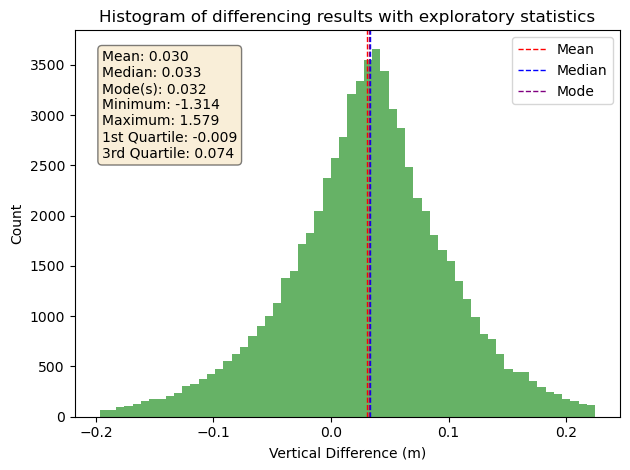

In [49]:
fig = stats_dtm.plot_data_stats()

<h3><a id="Variography"></a>Variography</h3>

This section uses the stable areas defined above to perform the geostatistical analysis. [cite_start]An experimental variogram is calculated from the DoD values within the stable areas, and then a mathematical model (nested spherical) is fitted to it[cite: 112, 121, 122]. [cite_start]This model captures the spatial correlation of the error, which is then used to propagate uncertainty across the entire study area[cite: 113, 127].

In [50]:
#Create variogram analysis instance based on modified raster
V = VariogramAnalysis(raster2_data_handler)

#Calculate a mean variogram with 75 bins from variograms made over 10 runs
V.calculate_mean_variogram_numba(area_side = 250, samples_per_area = 400, max_samples = 1000000000, bin_width = 30, max_n_bins = 3000, n_runs = 30, max_lag_multiplier = 0.6)

/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/variography_uncertainty_3.py:610: RuntimeWarning: Mean of empty slice
  mean_variogram = np.nanmean(vario_arr, axis=0)
/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:1620: RuntimeWarning: All-NaN slice encountered
  return fnb._ureduce(a,
/Users/cassandrabrigham/ASU Dropbox/Cassandra Brigham/Mac/Documents/POSTDOC/Code/OT_code/sage-gage-exercise/variography_uncertainty_3.py:613: RuntimeWarning: Mean of empty slice
  mean_count     = np.nanmean(count_arr, axis=0)
/opt/anaconda3/envs/sage-gage-exercise/lib/python3.12/site-packages/numpy/lib/_nanfunctions_impl.py:2019: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


In [51]:
V.fit_best_spherical_model()

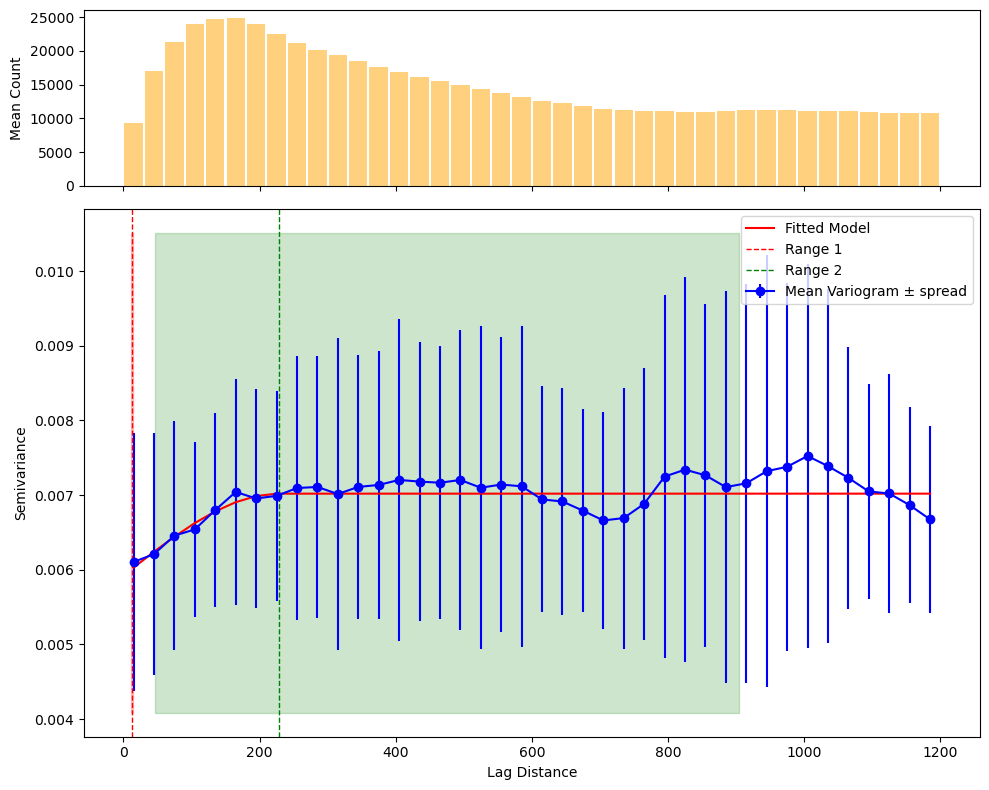

In [52]:
fig = V.plot_best_spherical_model()

<h3><a id="Total mean error"></a>Total mean error</h3>

In [57]:
interactor.map

Map(bottom=3487738.0, center=[29.013769957022205, -95.20975112915039], controls=(ZoomControl(options=['positio…

In [60]:
interactor.unstable_geoms

[<POLYGON ((-95.222 29.007, -95.222 29.006, -95.222 29.006, -95.221 29.006, -...>,
 <POLYGON ((-95.221 29.007, -95.221 29.007, -95.221 29.007, -95.221 29.006, -...>,
 <POLYGON ((-95.222 29.004, -95.221 29.004, -95.221 29.003, -95.221 29.003, -...>]

In [70]:
_, unstable_polys = interactor.get_geodataframes()

In [65]:
uncertainties_per_feature_of_interest = []
for i, poly in enumerate(unstable_polys['geometry']):
    uncertainty_temp = RegionalUncertaintyEstimator(raster2_data_handler, V, poly)
    uncertainty_temp.calc_mean_uncertainty(n_pairs=10000, level_of_detail = "bbox")
    uncertainties_per_feature_of_interest.append(uncertainty_temp)

In [67]:
uncertainties_per_feature_of_interest[0].print_results()

Variogram Analysis Results:
Ranges: [ 13.28754692 228.00748004]; min: [11.27796472 46.75228235]; max: [ 14.01364146 904.57194497]
Sills: [0.00591928 0.00109936]; min: [0.00385216 0.00054501]; max: [0.00659568 0.00328859]
Best Model Parameters: [5.91927883e-03 1.09935674e-03 1.32875469e+01 2.28007480e+02]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 6592.86
Mean Random Uncorrelated Uncertainty: 0.0003
Mean Random Correlated 1: 0.0345; min: 0.0566; max: 0.0229
Mean Random Correlated 2: 0.0801; min: 0.0808; max: 0.0805
Total Mean Correlated Uncertainty (Polygon): 0.0239; min: 0.0521; max: 0.0000
Total Mean Uncertainty (Polygon): 0.0239; min: 0.0521

Uncertainty Results for Raster:
Coarse raster Area (m²): 7782058.63
Mean Random Correlated 1 (Raster): 0.0332; min: 0.0563; max: 0.0206
Mean Random Correlated 2 (Raster): 0.0770; min: 0.0805; max: 0.0626
Total Mean Correlated Uncertainty (Raster): 0.0019; min: 0.0512; max: 0.0000
Total Mean Uncertainty (Raster): 0.0019; min

In [68]:
uncertainties_per_feature_of_interest[1].print_results()

Variogram Analysis Results:
Ranges: [ 13.28754692 228.00748004]; min: [11.27796472 46.75228235]; max: [ 14.01364146 904.57194497]
Sills: [0.00591928 0.00109936]; min: [0.00385216 0.00054501]; max: [0.00659568 0.00328859]
Best Model Parameters: [5.91927883e-03 1.09935674e-03 1.32875469e+01 2.28007480e+02]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 3774.03
Mean Random Uncorrelated Uncertainty: 0.0003
Mean Random Correlated 1: 0.0351; min: 0.0569; max: 0.0244
Mean Random Correlated 2: 0.0818; min: 0.0811; max: 0.0822
Total Mean Correlated Uncertainty (Polygon): 0.0300; min: 0.0529; max: 0.0185
Total Mean Uncertainty (Polygon): 0.0300; min: 0.0529; max: 0.0185

Uncertainty Results for Raster:
Coarse raster Area (m²): 7782058.63
Mean Random Correlated 1 (Raster): 0.0332; min: 0.0563; max: 0.0206
Mean Random Correlated 2 (Raster): 0.0770; min: 0.0805; max: 0.0625
Total Mean Correlated Uncertainty (Raster): 0.0022; min: 0.0512; max: 0.0000
Total Mean Uncertainty (Raster)

In [69]:
uncertainties_per_feature_of_interest[2].print_results()

Variogram Analysis Results:
Ranges: [ 13.28754692 228.00748004]; min: [11.27796472 46.75228235]; max: [ 14.01364146 904.57194497]
Sills: [0.00591928 0.00109936]; min: [0.00385216 0.00054501]; max: [0.00659568 0.00328859]
Best Model Parameters: [5.91927883e-03 1.09935674e-03 1.32875469e+01 2.28007480e+02]

Uncertainty Results for Polygon of interest:
Polygon Area (m²): 1956.18
Mean Random Uncorrelated Uncertainty: 0.0003
Mean Random Correlated 1: 0.0367; min: 0.0572; max: 0.0271
Mean Random Correlated 2: 0.0819; min: 0.0812; max: 0.0823
Total Mean Correlated Uncertainty (Polygon): 0.0322; min: 0.0535; max: 0.0219
Total Mean Uncertainty (Polygon): 0.0322; min: 0.0535; max: 0.0219

Uncertainty Results for Raster:
Coarse raster Area (m²): 7782058.63
Mean Random Correlated 1 (Raster): 0.0332; min: 0.0563; max: 0.0206
Mean Random Correlated 2 (Raster): 0.0770; min: 0.0805; max: 0.0625
Total Mean Correlated Uncertainty (Raster): 0.0021; min: 0.0512; max: 0.0000
Total Mean Uncertainty (Raster)